## Module

In [1]:
import os
import math
import zipfile
import numpy as np
import tensorflow as tf
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

#ImageDataGenerator
training_datagen = ImageDataGenerator(
    rescale=1. / 255,        #rescale: 이미지의 픽셀 값을 조정
    width_shift_range=0.2,   #width_shift_range: 가로 방향으로 이동
    height_shift_range=0.2,  #height_shift_range: 세로 방향으로 이동
    zoom_range = 0.2,        #zoom_range: 이미지 확대
    fill_mode = 'reflect',   #fill_mode: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
    validation_split=0.1,    #validation_split: validation set의 구성 비율
)

## Data

In [2]:
import shutil

def DeleteAllFiles(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
    else:
        os.makedirs(filePath)
        return 'Directory not Found and make director'        

TRAINING_DIR = "/content/train_data/"  
print(DeleteAllFiles(TRAINING_DIR))  

Directory not Found and make director


In [3]:
#압축풀기
local_zip = 'train_data.zip' 
image_file_path = '/content/train_data/'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(image_file_path)
zip_ref.close()

In [4]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=4, 
                                                          target_size=(150, 150), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 2351 images belonging to 118 classes.


In [5]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                            batch_size=4, 
                                                            target_size=(150, 150), 
                                                            class_mode='categorical',
                                                            subset='validation', 
                                                          )

Found 208 images belonging to 118 classes.


In [6]:
import os

dir_path = '/content/train_data'
file_list = []

for (root, directories, files) in os.walk(dir_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_list.append(file_path[20:23])

print(file_list)

my_set = set(file_list)
test_files = list(my_set)

files = [int (i) for i in test_files]

print(len(files))

['210', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '219', '202', '202', '202', '202', '202', '202', '318', '102', '102', '102', '102', '135', '135', '135', '135', '135', '135', '135', '135', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224', '224'

## Model

In [7]:
model = Sequential([
    Conv2D(64, (3, 3), activation='PReLU', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='PReLU'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='PReLU'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='PReLU'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='softmax'),
    MaxPooling2D(2, 2), 


    Flatten(), 
    Dropout(0.5),
    Dense(512, activation='PReLU'),
    Dense(128, activation='PReLU'),
    Dense(32, activation='PReLU'),
    Dense(118, activation='softmax'),   
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1403648   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       737408    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       295552    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Compile

In [9]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## Train

In [11]:
#학습 회수 선정
epochs = 300

In [12]:
history = model.fit(training_generator, 
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint],
                    )

Epoch 1/300
587/588 [============================>.] - ETA: 0s - loss: 4.5161 - acc: 0.0460
Epoch 1: val_loss improved from inf to 4.06225, saving model to tmp_checkpoint.ckpt
588/588 [==============================] - 26s 26ms/step - loss: 4.5164 - acc: 0.0459 - val_loss: 4.0622 - val_acc: 0.0913
Epoch 2/300
587/588 [============================>.] - ETA: 0s - loss: 4.2305 - acc: 0.0724
Epoch 2: val_loss improved from 4.06225 to 3.99930, saving model to tmp_checkpoint.ckpt
588/588 [==============================] - 15s 25ms/step - loss: 4.2299 - acc: 0.0732 - val_loss: 3.9993 - val_acc: 0.0913
Epoch 3/300
587/588 [============================>.] - ETA: 0s - loss: 4.1487 - acc: 0.0733
Epoch 3: val_loss improved from 3.99930 to 3.92007, saving model to tmp_checkpoint.ckpt
588/588 [==============================] - 15s 25ms/step - loss: 4.1490 - acc: 0.0732 - val_loss: 3.9201 - val_acc: 0.0913
Epoch 4/300
588/588 [==============================] - ETA: 0s - loss: 4.1173 - acc: 0.0732
Epo

In [13]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


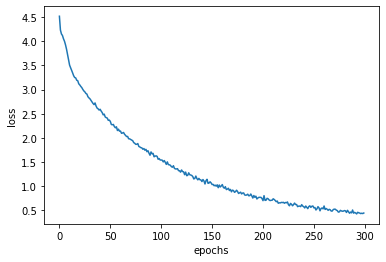

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']) # loss 그래프
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

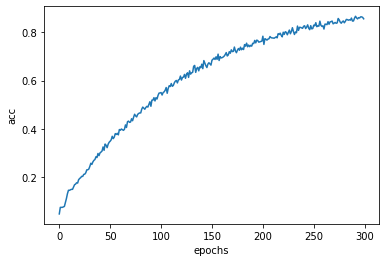

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc']) # acc 그래프
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

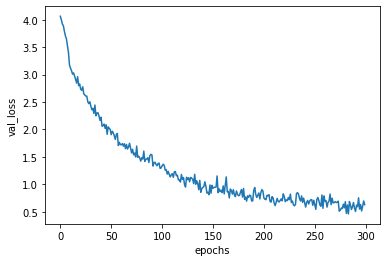

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss']) # val_loss 그래프
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.show()

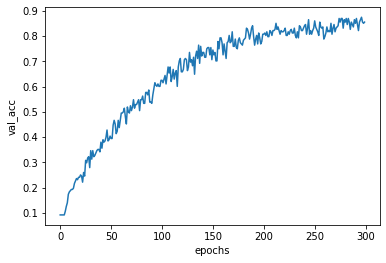

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc']) # val_acc 그래프
plt.xlabel('epochs')
plt.ylabel('val_acc')
plt.show()

## Load Weights

In [18]:
model.load_weights(checkpoint_path)

In [19]:
model.save("부천고_road_sign_detector.h5")